## Sklearn pipelines

Pipelines are specially usefull to package the preprocessing of the data and model fitting in a single (serializable) object that can be used even with crossvalidation.


In [1]:
import sklearn
from sklearn import pipeline
from sklearn import svm
from sklearn.datasets import samples_generator
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dataset = sklearn.datasets.fetch_20newsgroups()
X_str = dataset.data
y = dataset.target
len(X_str), len(y)

(11314, 11314)

In [3]:
X_str[0], y[0]

("From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 7)

## Document classifier example

Now we want to build a document classifier that will contain essentially 2 components

- An encoder that will generate a vector from a string
- A classifier that will generate a class label from a vector

Here there are different decisions that we want to tune:

- Decisions made at encoding time
- Decisions made at classification time


In [4]:
sklearn.model_selection.train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, **options)>

In [5]:
X_str_tr, X_str_te, y_tr, y_te = sklearn.model_selection.train_test_split(X_str,y)

## Example 1: We ignore tunning the count vectorizer

In [6]:
encoder = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,1),max_features=100000)
clf = sklearn.linear_model.LogisticRegression(C=1)
C_values = np.round(np.linspace(0.1,10,8),2)

pipe = Pipeline([('encoder', encoder), ('clf', clf)])
pipe

Pipeline(steps=[('encoder', CountVectorizer(max_features=100000)),
                ('clf', LogisticRegression(C=1))])


When we specify a parameter grid, we can specify the values that we want to evaluate while tunning.
Since a pipeline can combine multiple steps, we need to specify where a parameter belongs. We can do this using the name
of the step followed by `__` and then the name of the parameter.

For example:
    
- If we want to search over a list `C_values` the `C` parameter of `clf` we can tell the GrifSearchCV: `{'clf__C':C_values}`

In [7]:
pipe_search = sklearn.model_selection.GridSearchCV(estimator=pipe,
                                                   param_grid={'clf__C': C_values},
                                                   cv=2, 
                                                   n_jobs=-1)

In [8]:
pipe_search.fit(X_str_tr, y_tr)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('encoder',
                                        CountVectorizer(max_features=100000)),
                                       ('clf', LogisticRegression(C=1))]),
             n_jobs=-1,
             param_grid={'clf__C': array([ 0.1 ,  1.51,  2.93,  4.34,  5.76,  7.17,  8.59, 10.  ])})

After the object is fitted we can inspect the results achieved during search which are stored in `.cv_results_`

In [9]:
pipe_search.cv_results_

{'mean_fit_time': array([94.51085746, 96.46326363, 97.69822407, 96.62041688, 87.27910197,
        86.92533135, 87.15953493, 87.1630975 ]),
 'std_fit_time': array([1.36093628, 2.39317858, 0.57575679, 2.31402087, 4.16840994,
        0.17159939, 1.55632901, 0.62093365]),
 'mean_score_time': array([1.99964893, 1.98519099, 2.08305097, 1.95183849, 1.39377189,
        1.48912668, 1.09192264, 1.02355337]),
 'std_score_time': array([0.11751497, 0.015921  , 0.04466391, 0.02235651, 0.2145381 ,
        0.08570838, 0.23582852, 0.10467958]),
 'param_clf__C': masked_array(data=[0.1, 1.51, 2.93, 4.34, 5.76, 7.17, 8.59, 10.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__C': 0.1},
  {'clf__C': 1.51},
  {'clf__C': 2.93},
  {'clf__C': 4.34},
  {'clf__C': 5.76},
  {'clf__C': 7.17},
  {'clf__C': 8.59},
  {'clf__C': 10.0}],
 'split0_test_score': array([0.82441669, 0.82936601, 0.82748056, 0.82653783, 0.8291

The best `C` value found during `pipe_search.fit` is

In [10]:
pipe_search.best_params_

{'clf__C': 1.51}

<AxesSubplot:title={'center':'CV validation accuracy'}>

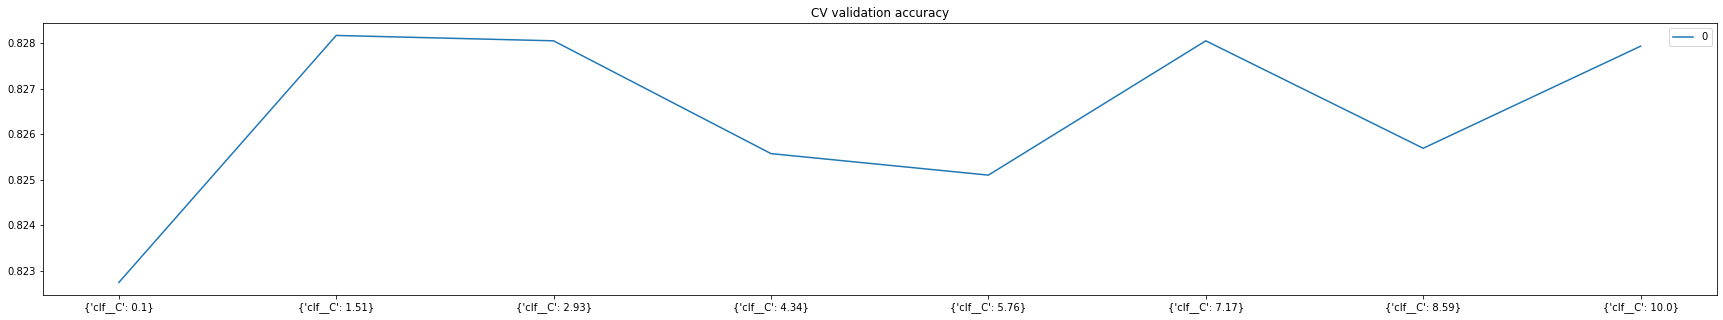

In [19]:
import pandas as pd

df_pipe_search = pd.DataFrame( pipe_search.cv_results_['mean_test_score'])
df_pipe_search.index =pipe_search.cv_results_['params']
df_pipe_search.plot(title='CV validation accuracy', figsize=(30,5))

In [12]:
te_acc = np.mean(pipe_search.predict(X_str_te) ==y_te)
print(f'test accuracy: ', te_acc)

test accuracy:  0.8716861081654295


## Tunning both embedding size and classifier

We can tune interactions between parameters of the encoder and classifier tuninng a pipeline object

In [13]:
encoder = sklearn.feature_extraction.text.CountVectorizer(max_features=100000)
clf = sklearn.linear_model.LogisticRegression(C=1)

C_values = np.round(np.linspace(0.1,10,8),2)
ngram_ranges = [(1,1),(1,2),(1,3),(1,4)]

In [14]:
pipe_search2 = sklearn.model_selection.GridSearchCV(estimator=pipe,
                                                   param_grid={'clf__C': C_values,
                                                               'encoder__ngram_range':ngram_ranges},
                                                   cv=2, 
                                                   n_jobs=-1)

In [15]:
pipe_search2.fit(X_str_tr, y_tr)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('encoder',
                                        CountVectorizer(max_features=100000)),
                                       ('clf', LogisticRegression(C=1))]),
             n_jobs=-1,
             param_grid={'clf__C': array([ 0.1 ,  1.51,  2.93,  4.34,  5.76,  7.17,  8.59, 10.  ]),
                         'encoder__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                  (1, 4)]})

<AxesSubplot:title={'center':'CV validation accuracy'}>

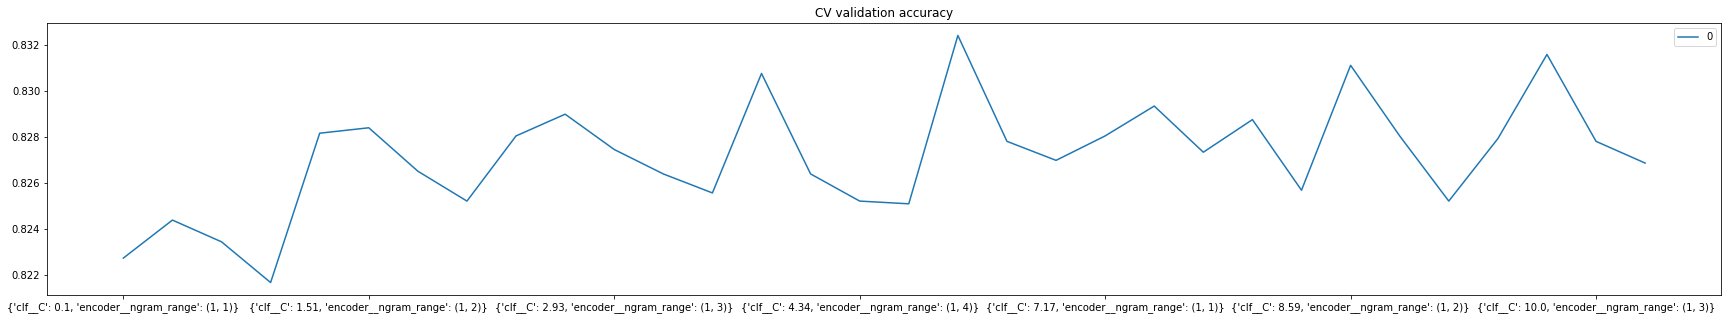

In [17]:
import pandas as pd

df_pipe_search = pd.DataFrame( pipe_search2.cv_results_['mean_test_score'])
df_pipe_search.index =pipe_search2.cv_results_['params']
df_pipe_search.plot(title='CV validation accuracy', figsize=(30,5))

In [18]:
te_acc = np.mean(pipe_search2.predict(X_str_te) ==y_te)
print(f'test accuracy: ', te_acc)

test accuracy:  0.8755744079179922
